In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.signal import square
from scipy.integrate import quad
from numpy import sqrt, exp, pi, cos, sin, log, abs
from scipy.stats import norm, expon, lognorm
import pandas as pd
from time import perf_counter
from tqdm  import tqdm
from numba import njit

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')
np.seterr(all = 'ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# Global color shades
blue_shades     = ['#0000FF', '#3399FF', '#66B2FF', '#99CCFF', '#CCE5FF']
green_shades    = ['#005500', '#009900', '#00CC00', '#66FF66', '#99FF99']

# Part 1
----------------------------------------------------------------
from Medium.com : https://medium.com/@alexander.tsoskounoglou/pricing-options-with-fourier-series-p1-5bf60443ba0c 

## Introduction
For a function $f(x)$ with for a range a,b we can transform it as:
$$\begin{align*}
& f(x) &\approx& A_0 + \sum_{n=1}^{\infty}A_n*cos\bigg(\frac{2\pi xn}{b-a}\bigg) + B_n*sin\bigg(\frac{2\pi xn}{b-a}\bigg) \\
& A_0  &=& \frac{1}{b-a}\int_{a}^{b} f(x)dx \quad for \; n\ge 1\\
& A_n  &=& \frac{2}{b-a}\int_{a}^{b} f(x)*cos\bigg(\frac{2\pi xn}{b-a}\bigg)dx \quad for \; n\ge 1\\
& B_n  &=& \frac{2}{b-a}\int_{a}^{b} f(x)*sin\bigg(\frac{2\pi xn}{b-a}\bigg)dx \quad for \; n\ge 1\\
\end{align*}$$

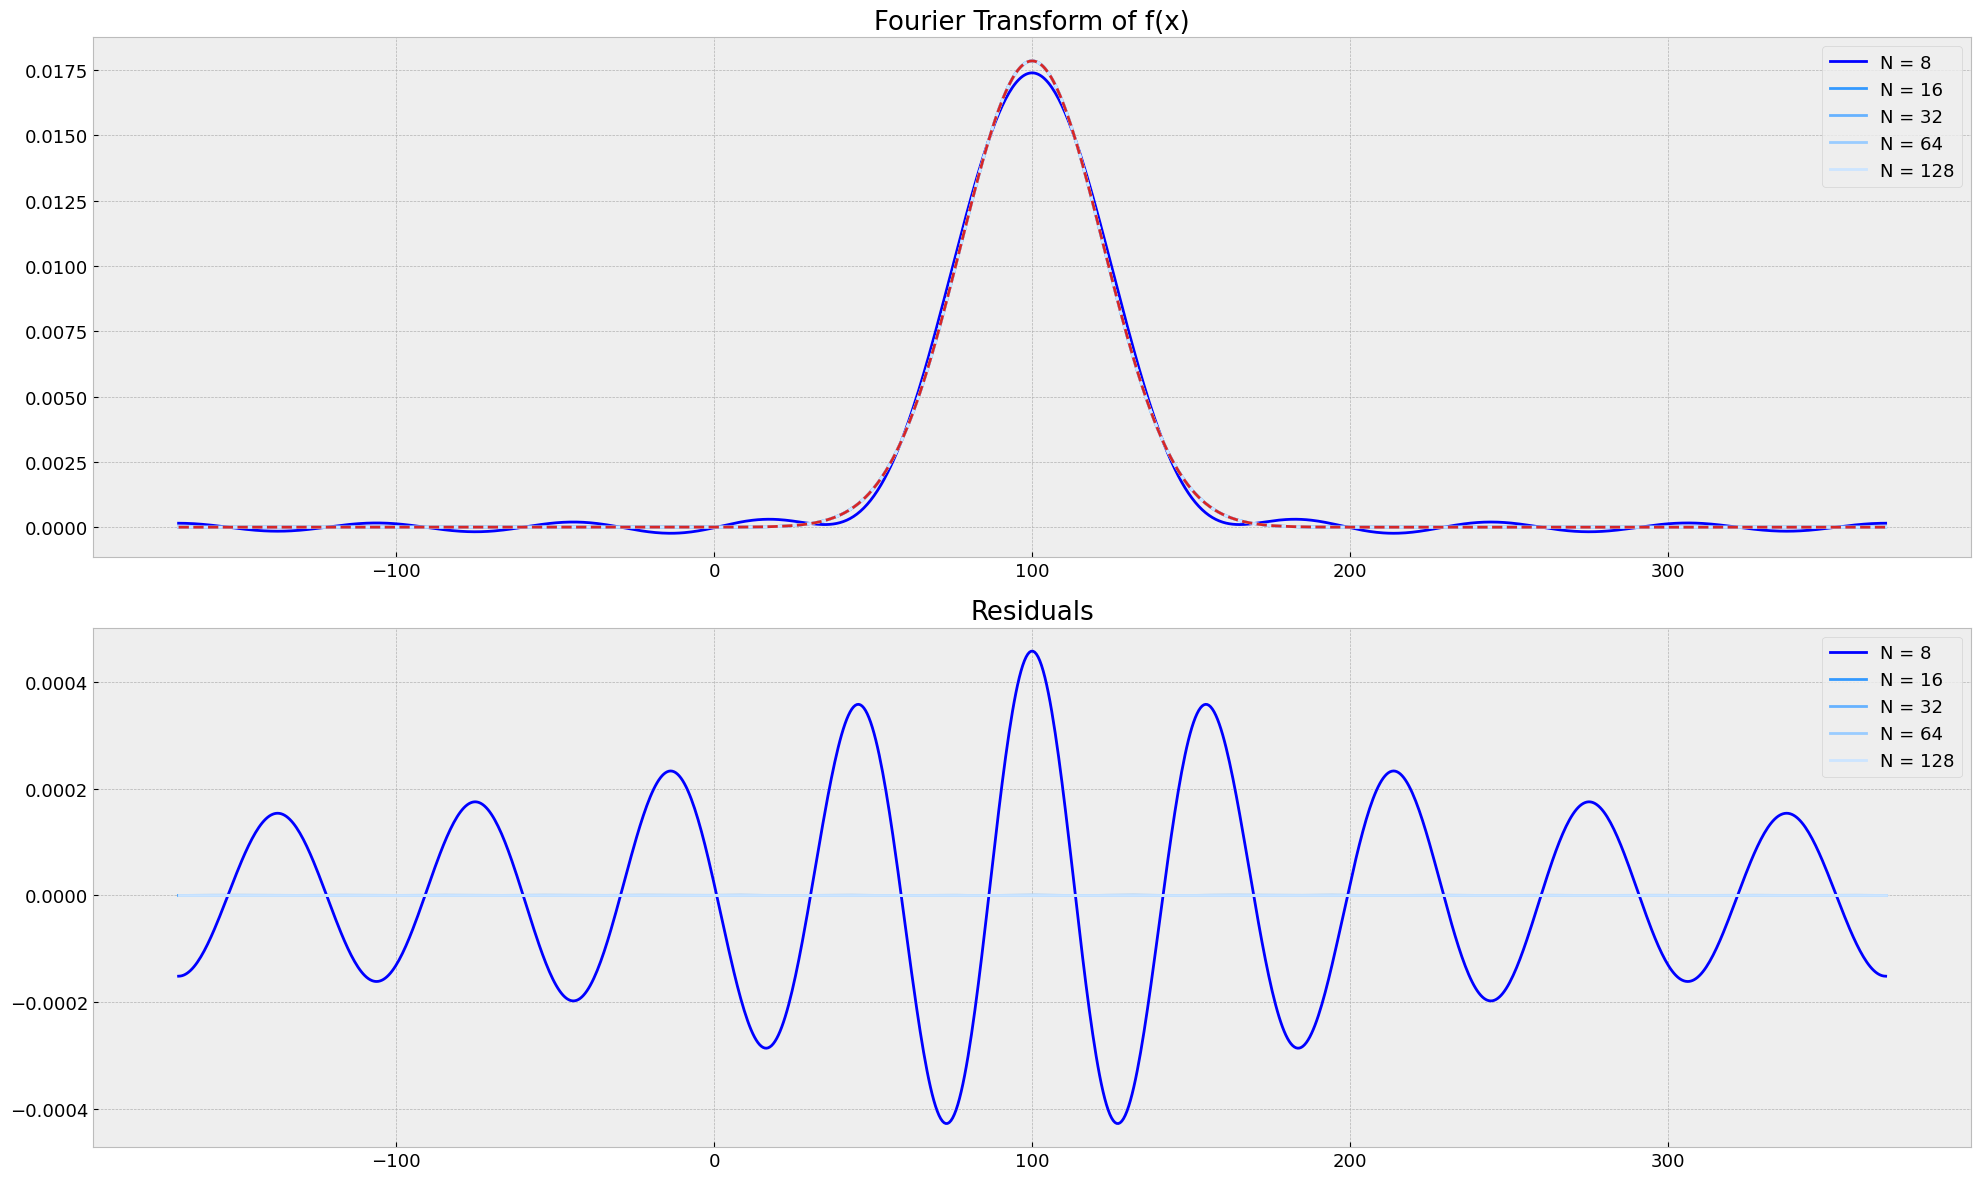

,Avg Residual
8,1.593045e-04
16,1.214211e-07
32,7.100142e-18
64,3.628299e-14
128,2.992953e-12


In [4]:
def get_fourier_approx(f, x:np.array, a:float, b:float, N:int):
    fa = lambda x, n : f(x) * cos((2*pi*n*x)/(b - a))
    fb = lambda x, n : f(x) * sin((2*pi*n*x)/(b - a))

    A0 = 1/(b - a) * quad(f, a, b, limit=200)[0]

    Cosine_Sine_Sum = np.zeros_like(x)
    for n in range(1, N+1):
        A = 2/(b - a) * quad(fa, a, b, args=(n), limit=200)[0]
        B = 2/(b - a) * quad(fb, a, b, args=(n), limit=200)[0]
        Cosine_Sine_Sum += A*cos((2*pi*n*x)/(b - a)) + B*sin((2*pi*n*x)/(b - a))

    fx = A0 + Cosine_Sine_Sum
    return fx


mean = 100
std  = .1 *sqrt(5)*100 
f = lambda x : (1/(std*sqrt(2*pi))) * exp(-(x-mean)**2/(2*std**2)) #*12/0.0175
# f = lambda x : square(x)*6
# f = lambda x : x

a = mean - 12 * std
b = mean + 12 * std

# a = -6
# b = 6

x = np.linspace(a, b, 1_000)
y = f(x)

fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))

avg_residuals = []
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):
    fx = get_fourier_approx(f=f, x=x, a=a, b=b, N=N)
    ax1.plot(x,fx, blue_shades[i], label=f'N = {N}')
    ax2.plot(x,y-fx, blue_shades[i], label=f'N = {N}')
    avg_residuals.append(np.abs(y-fx).mean())

ax1.set_title('Fourier Transform of f(x)')
ax1.plot(x,y,'tab:red', linestyle='--')
ax2.set_title('Residuals')
plt.tight_layout() ; ax1.legend();ax2.legend() ; plt.show()

pd.DataFrame(avg_residuals, index=Ns, columns=['Avg Residual'])

## Log normal distribution of $S_t$
$$\begin{align*}
& N(z)   &=\;& \frac{1}{\sqrt{2\pi}} exp\bigg\{-\frac{z^2}{\sigma^2}\bigg\} & \\
& S_T(z) &=\;& S_0 exp\bigg\{(r-\frac{1}{2}\sigma^2)T + \sigma\sqrt{T}z \bigg\} & = S_T\\
& S_T^{-1}(S_T) &=\;& \frac{log(\frac{S_T}{S_0})-(r-\frac{1}{2}\sigma^2)T}{\sqrt T \sigma} & = z\;\;\\
& \mathbb{P}[S_T|S_0] &=\;& N(S_T^{-1}(S_T)) &\\
& a &=\;& S_T(-12) &\\
& b &=\;& S_T(12) &\\
\end{align*}$$

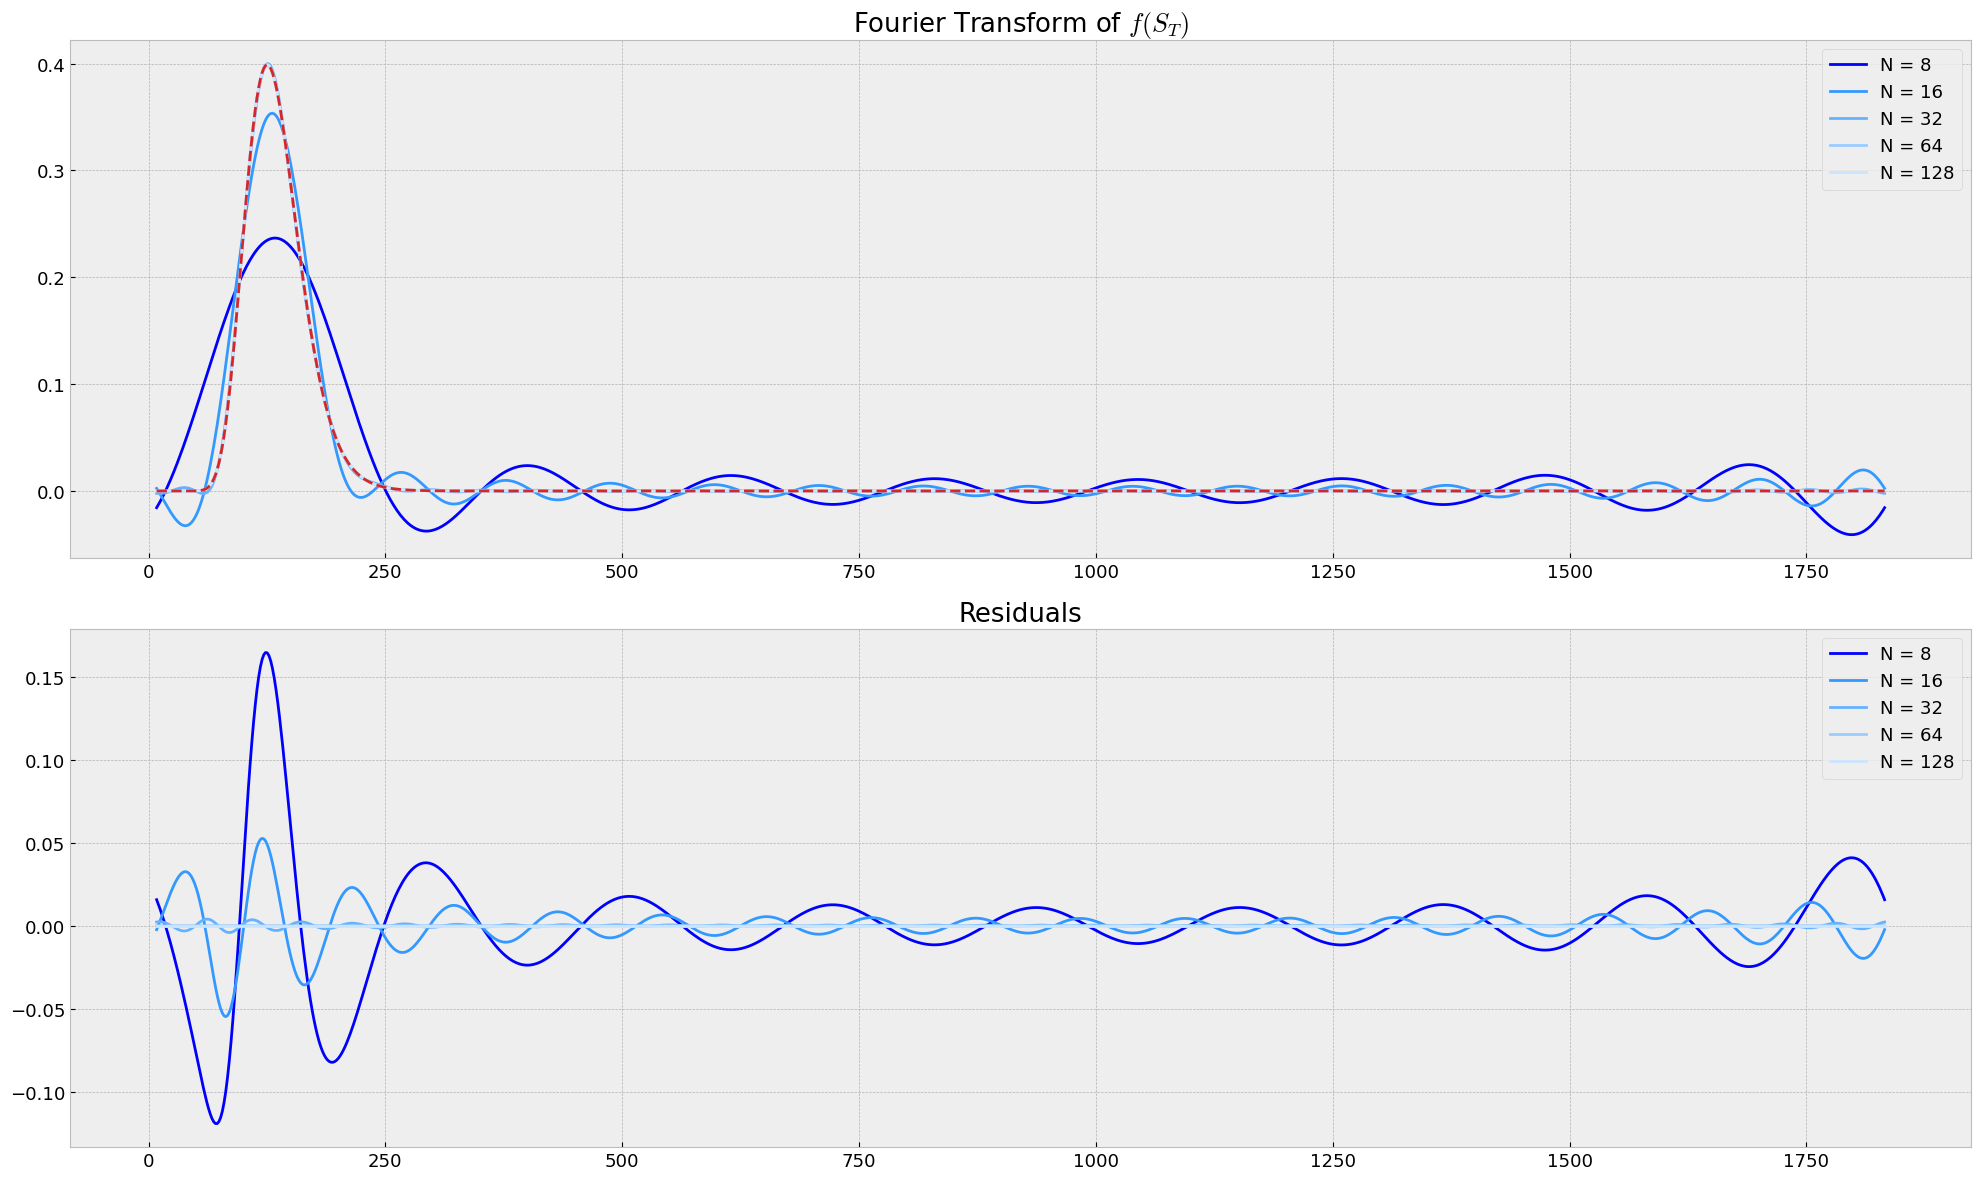

,Avg Residual
8,1.897794e-02
16,7.159815e-03
32,5.616416e-04
64,2.326956e-06
128,1.384069e-10


In [5]:
def get_fourier_approx(f, x:np.array, a, b, N:int):
    limit = 1000
    L = b - a
    upper = b
    lower = a 
    # print(f"L = {L} \nupper = {upper} \nlower = {lower}")

    fa = lambda x, n : f(x) * cos((2*pi*n*x)/(L))
    fb = lambda x, n : f(x) * sin((2*pi*n*x)/(L))

    A0 = (1/L) * quad(f, lower, upper, limit=limit)[0]

    Cosine_Sine_Sum = np.zeros_like(x)
    for n in range(1, N+1):
        A = (2/L) * quad(fa, lower, upper, args=(n), limit=limit)[0]
        B = (2/L) * quad(fb, lower, upper, args=(n), limit=limit)[0]
        Cosine_Sine_Sum += A*cos((2*pi*n*x)/(L)) + B*sin((2*pi*n*x)/(L))

    fx = A0 + Cosine_Sine_Sum
    return fx


S0      = 100
K       = 100
r       = 0.05
sigma   = 0.1
T       = 5.0

S_T     = lambda z : S0*exp((r-.5*sigma**2)*T + sigma*sqrt(T)*z)
S_T_inv = lambda S_T : (log(S0/S_T) + (r - .5*sigma**2)*T)/(sqrt(T)*sigma)
f       = lambda S_T : norm.pdf(S_T_inv(S_T)) # P[S_T = X]


a   = S_T(-12)
b   = S_T(12)
x   = np.linspace(a, b, 1_000)
y   = f(x)

fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))

avg_residuals = []
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):
    fx = get_fourier_approx(f=f, x=x, a=a, b=b, N=N)
    ax1.plot(x,fx, blue_shades[i], label=f'N = {N}')
    ax2.plot(x,(y-fx), blue_shades[i], label=f'N = {N}')
    avg_residuals.append(np.abs(y-fx).mean())

ax1.set_title(r'Fourier Transform of $f(S_T)$')
ax1.plot(x,y,'tab:red', linestyle='--')
ax2.set_title('Residuals')
plt.tight_layout() ; ax1.legend() ; ax2.legend() ; plt.show()

pd.DataFrame(avg_residuals, index=Ns, columns=['Avg Residual'])

## Timeings

In [6]:
x = np.array([100.0])
Ns = [8, 16, 32, 64, 128]
timings = []
for i, N in tqdm(enumerate(Ns), total=5):
    avg_time = []
    for _ in range(10):
        t = perf_counter()
        _ = get_fourier_approx(f=f, x=x, a=a, b=b, N=N)
        avg_time.append(perf_counter() - t)
    timings.append(np.mean(avg_time))

pd.DataFrame(timings, index=Ns, columns=['Execution Time'])

100%|██████████| 5/5 [01:09<00:00, 13.95s/it]


,Execution Time
8,0.119602
16,0.233654
32,0.556611
64,1.536179
128,4.530423


In [7]:
"""
N       Avg. (scaled) Residual      Avg. Residual       Execution Time (sec)
----------------------------------------------------------------------------
8	    0.176429                    5.880975e-03        0.112720 
16	    0.004235                    1.411566e-04        0.246473 
32	    0.000030 	                9.855127e-07        0.624209 
64	    0.000027 	                8.918504e-07        1.936948 
128	    0.000026 	                8.530034e-07        6.741019
""" ; 

# Part 2
--------------------------------------
## Fourier cosine expansion

The Fourier-cosine expansion theorem states that any integrable function f on an interval
[a, b] can be written as an infinite sum of cosine functions, since:

$$\begin{align*}
&f(x) &=& \frac{1}{2}A_0 + \sum_{n=1}^{\infty}A_n cos(n\pi\frac{x-a}{b-a}) \\
&A_n &=& \frac{2}{b-a}\int_a^bf(x)cos(n\pi\frac{x-a}{b-a})dx \\
\end{align*}$$

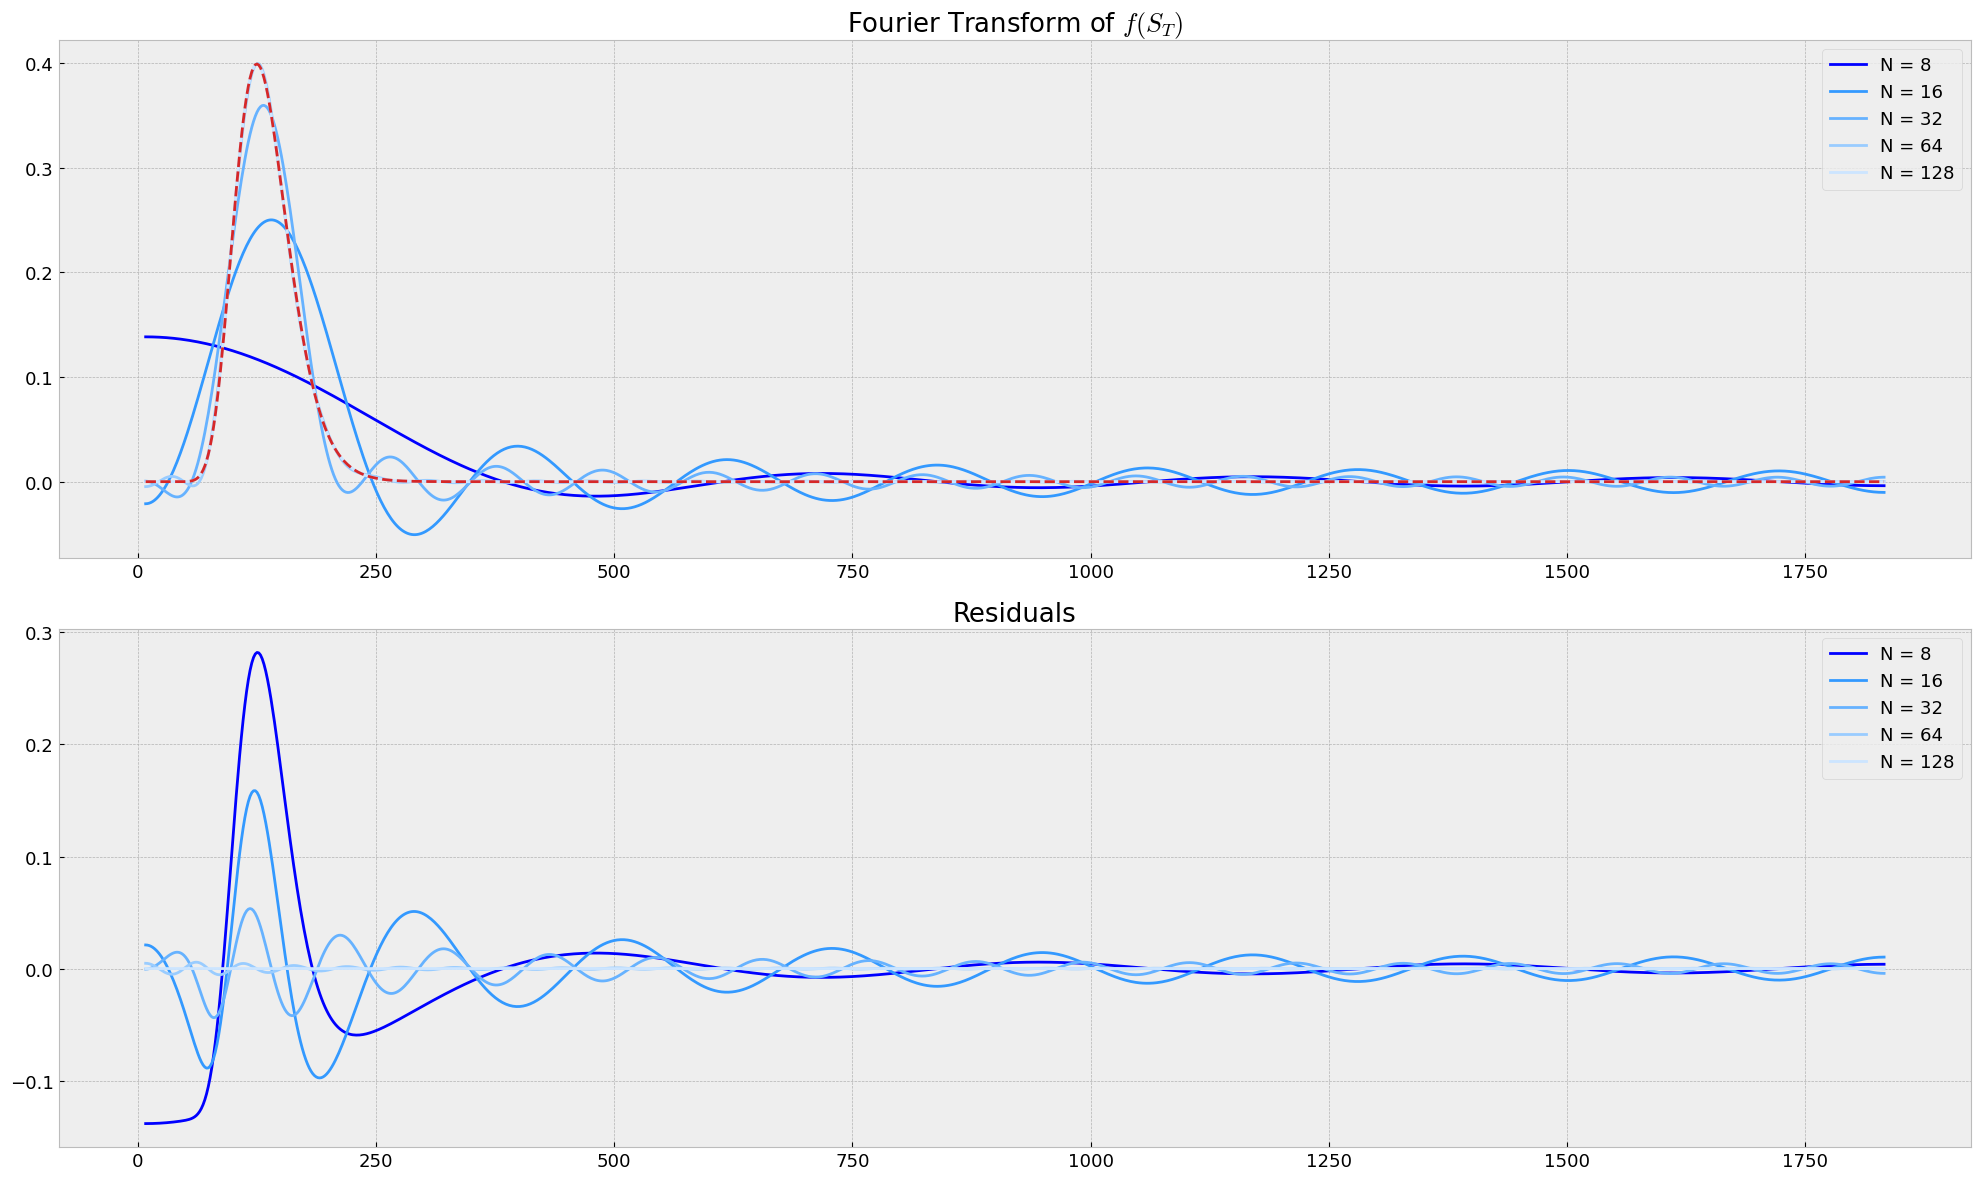

,Avg Residual
8,0.020561
16,0.018211
32,0.006961
64,0.000559
128,0.000003


In [8]:
def Fourier_cosine(f, x:np.array, a, b, N:int):
    ql = 1000 # quad_limit

    fa = lambda x, n : f(x) * cos(n*pi * (x-a)/(b-a))
    A  = lambda x, n : 2/(b-a) * quad(fa, a, b, limit=ql, args=(n))[0] * cos(n*pi * (x-a)/(b-a))

    fx = .5*A(x, 0)
    for n in range(1, N+1):
        fx += A(x, n)
    
    return fx


S0      = 100
K       = 100
r       = 0.05
sigma   = 0.1
T       = 5.0

# ----------------------------------------------------------------
S_T     = lambda z : S0*exp((r-.5*sigma**2)*T + sigma*sqrt(T)*z)
S_T_inv = lambda S_T : (log(S0/S_T) + (r - .5*sigma**2)*T)/(sqrt(T)*sigma)
f       = lambda S_T : norm.pdf(S_T_inv(S_T)) # P[S_T = X]


a   = S_T(-12)
b   = S_T(12)
x   = np.linspace(a, b, 1_000)
y   = f(x)

fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))

avg_residuals = []
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):
    fx = Fourier_cosine(f=f, x=x, a=x[0], b=x[-1], N=N)
    ax1.plot(x,fx, blue_shades[i], label=f'N = {N}')
    ax2.plot(x,(y-fx), blue_shades[i], label=f'N = {N}')
    avg_residuals.append(np.abs(y-fx).mean())

ax1.set_title(r'Fourier Transform of $f(S_T)$')
ax1.plot(x,y,'tab:red', linestyle='--')
ax2.set_title('Residuals')
plt.tight_layout() ; ax1.legend() ; ax2.legend() ; plt.show()

pd.DataFrame(avg_residuals, index=Ns, columns=['Avg Residual'])

## Approximating the $A_n$ terms using the characteristic function and analytically solving the integral

### Step 1 : Euler's Formula to transform $\cos(x)$
$$\begin{align*}
& e^{ix} &=\;& \cos(x) + i\sin(x) & \\
\Rightarrow \quad & \cos(x) &=\;& e^{ix} \quad &
\text{, Since $isin(x)=0$ in the cosine transform} \\
\Rightarrow \quad & \cos(n\pi\frac{x-a}{b-a}) &=\;& e^{in\pi\frac{x-a}{b-a}} \\
\\
\Rightarrow \quad & A_n &=& \frac{2}{b-a}\int_a^bf(x)\cos(n\pi\frac{x-a}{b-a})dx \\
                  &  &=& \frac{2}{b-a} Re\bigg[\int_a^bf(x)e^{in\pi\frac{x-a}{b-a}}dx\bigg] \\
\end{align*}$$

### Step 2 : Characteristic function of $f(x)$
In probability theory, a characteristic function is a complex-valued function defined for a random variable. It captures the moments and distributional properties of the random variable, allowing for the analysis of various statistical properties using techniques such as Fourier transforms. For example for a random noraml variable:
$$\begin{align*}
& \varphi_X(u) &=\;& \mathbb{E}\big[ e^{iuX}\big] & u \in \R \\
& \varphi_X(u) &=\;& e^{iu\mu-\frac{1}{2}\sigma^2u^2} & \quad\text{If $X \sim N(\mu,\sigma^2)$} \\
& \varphi_X(u) &=\;& e^{\lambda(e^{iu-1})} & \quad\text{If $X \sim Poisson(\lambda)$} \\
\end{align*}$$


In our use case we can transform the density function of i.e. $log(S_T)$. Bellow $f$ is the density of a random variable $Z$ with a known characteristic function $\varphi_Z(u)$. For example if $Z$ is a random normal variable we can use the equation above:

$$\begin{align*}
\\
& \int_a^bf(z)e^{in\pi\frac{z-a}{b-a}}dz = \int_a^bf(z)e^{in\pi\frac{z}{b-a}}e^{in\pi\frac{a}{b-a}}dz = e^{in\pi\frac{-a}{b-a}}\int_a^bf(z)e^{in\pi\frac{z}{b-a}}dz \\
\\
Since, \quad & \int_a^bf(z)e^{in\pi\frac{z}{b-a}}dz = \mathbb{E}\big[ e^{in\pi\frac{z}{b-a}}\big] \\
\Rightarrow \quad & \int_a^bf(z)e^{in\pi\frac{z-a}{b-a}}dz = \mathbb{E}\big[ e^{in\pi\frac{z}{b-a}}\big]e^{in\pi\frac{-a}{b-a}} \\
\\
Since, \quad &  \varphi_z(1) =  \mathbb{E}\big[ e^{iz}\big]  \\
\Rightarrow \quad & \varphi_z(\frac{n\pi}{b-a}) = \mathbb{E}\big[ e^{in\pi\frac{z}{b-a}}\big] \\
\\
\end{align*}$$
Therefore,
$$\begin{align*}
A_n &=\;&\frac{2}{b-a}Re\bigg[ \mathbb{E}\big[ e^{in\pi\frac{z}{b-a}}\big] e^{in\pi\frac{-a}{b-a}} \bigg] + E_n \\
    &=\;& \frac{2}{b-a}Re\bigg[ \varphi_z(\frac{n\pi}{b-a}) e^{in\pi\frac{-a}{b-a}} \bigg] + E_n \\
\end{align*}$$
Where $E_n$ is the part of the integral outside of $[a,b]$ which is very small if for probability mass $f(x)$ we pick $a,b$ where $f(x)$ is close to zero. Similar concept can be applied if $f(x)$ is the payoff of an option and the payoff is very small for $a,b$

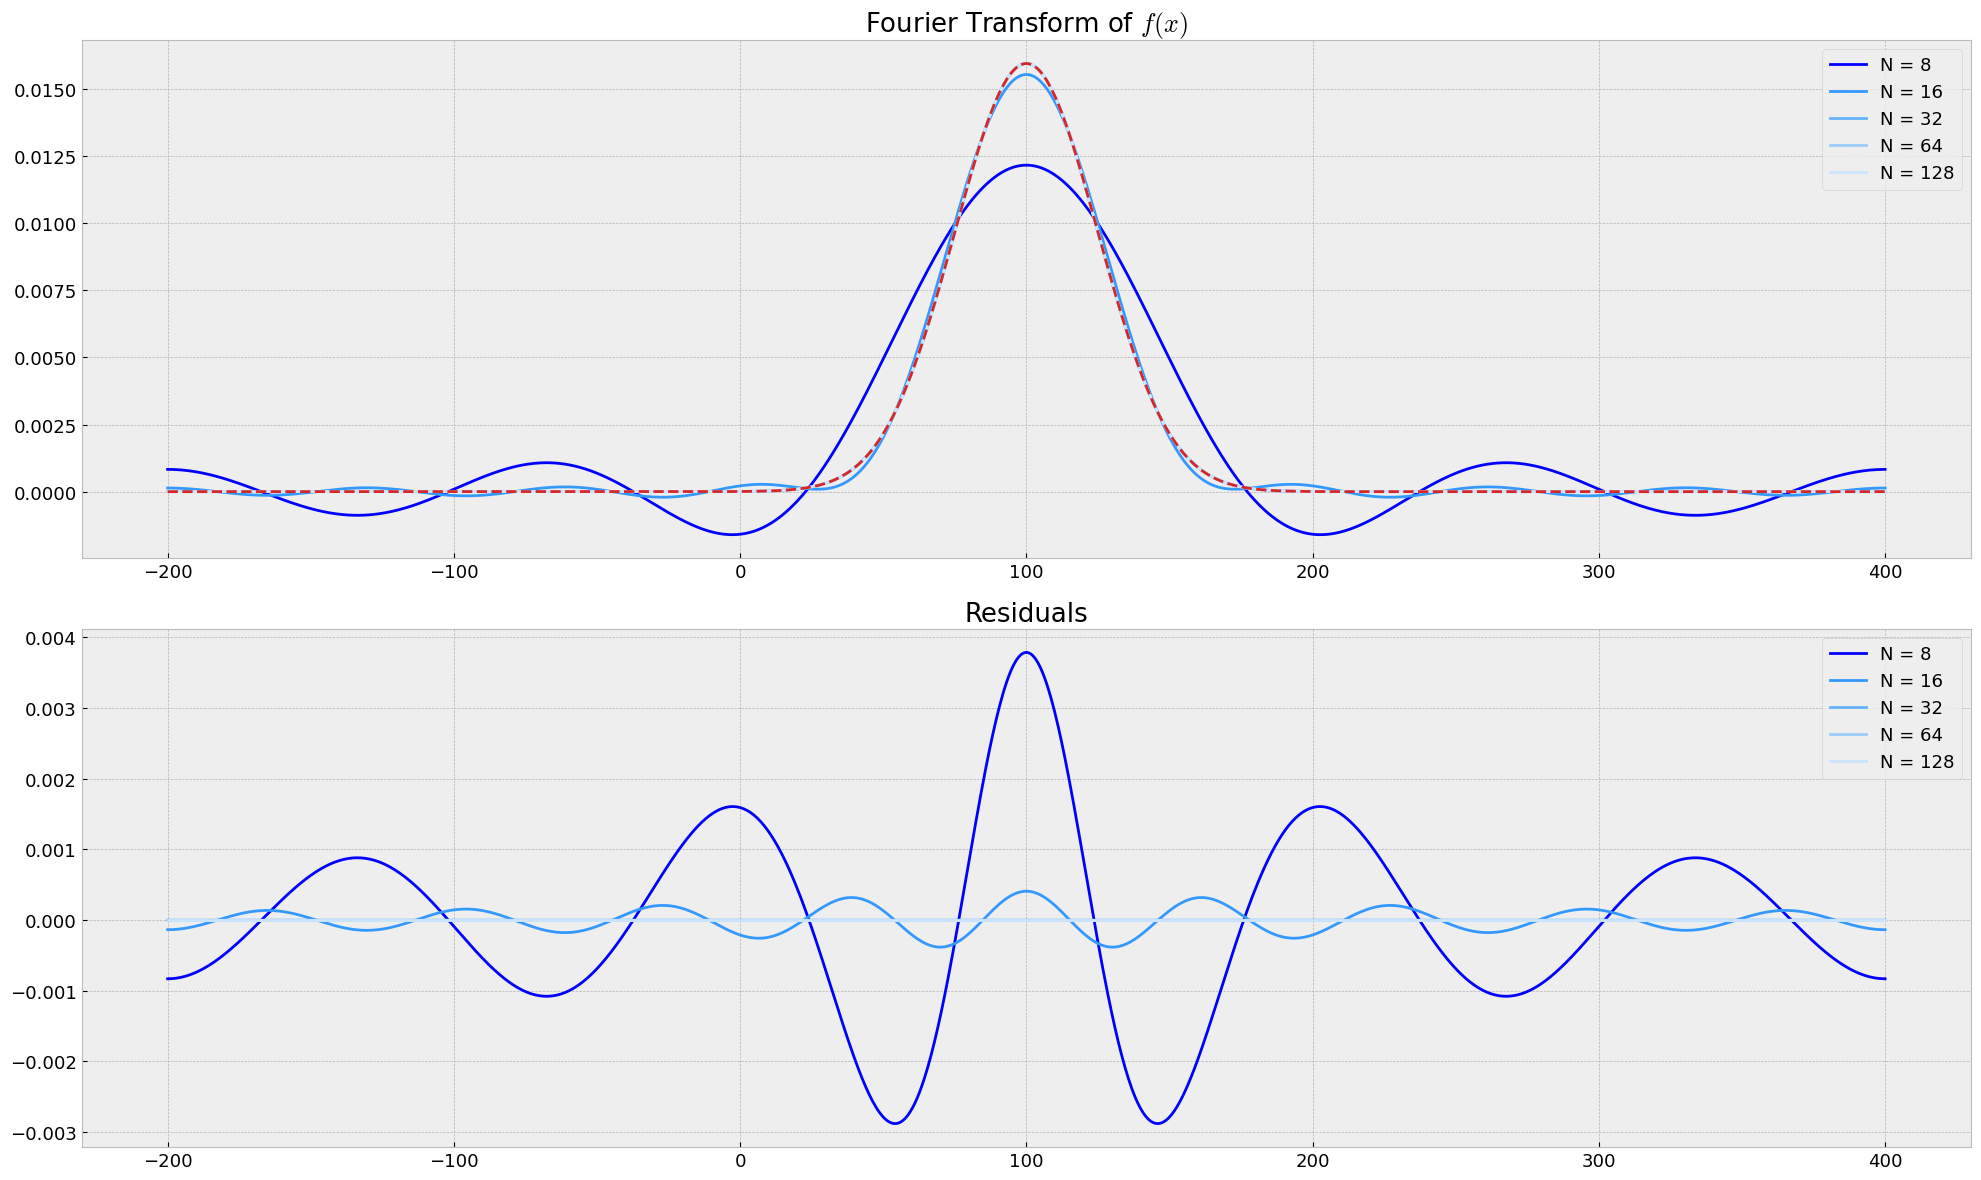

,avg_residuals,Ex. Time
N,,
8,1.036451e-03,0.000054
16,1.424863e-04,0.000092
32,1.086024e-07,0.000181
64,2.902947e-18,0.000351
128,2.904371e-18,0.000702


In [9]:
def Fourier_cosine_char_function(char_function, x:np.array, a, b, N:int):

    A  = lambda n : 2/(b-a) * np.real( char_function((n*pi)/(b-a))*exp((-1j*n*pi*a)/(b-a))  )
    fx = .5*A(0)
    for n in range(1, N+1):
        fx += A(n) * cos(n*pi * (x-a)/(b-a))
    
    return fx

# --------------------------------------------------------------------------------------------------------------------------------

S0      = 100
K       = 100
r       = 0.05
sigma   = 0.1
T       = 5.0

# For normal distribution 
mu      = 100
sigma   = 25
char_function = lambda u: exp(1j*u*mu -.5*sigma**2*u**2)
f             = lambda x: norm.pdf(x, loc=mu, scale=sigma)

a   = 100 - 12 * sigma
b   = 100 + 12 * sigma

# # For Exonential distribution 
# l = 1
# char_function = lambda u: l/(l - 1j*u)
# f             = lambda x: expon.pdf(x)

# a   = 0
# b   = l + 12 * (1/l)

# --------------------------------------------------------------------------------------------------------------------------------
x   = np.linspace(a, b, 1_000)
y   = f(x)

fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))

results = {'N': [], 'avg_residuals': [] , 'Ex. Time' : []}
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):
    fx = Fourier_cosine_char_function(char_function=char_function, x=x, a=a, b=b, N=N)
    ex_time = []
    for _ in range(15):
        timer =perf_counter()
        _ = Fourier_cosine_char_function(char_function=char_function, x=np.array([100]), a=a, b=b, N=N)
        timer = perf_counter() - timer ; ex_time.append(timer)
    
    ax1.plot(x,fx, blue_shades[i], label=f'N = {N}')
    ax2.plot(x,(y-fx), blue_shades[i], label=f'N = {N}')
    results['N'].append(N)
    results['avg_residuals'].append(np.abs(y-fx).mean())
    results['Ex. Time'].append(np.mean(ex_time))

ax1.set_title(r'Fourier Transform of $f(x)$')
ax1.plot(x,y,'tab:red', linestyle='--')
ax2.set_title('Residuals')
plt.tight_layout() ; ax1.legend() ; ax2.legend() ; plt.show()

pd.DataFrame.from_dict(results).set_index('N')

## Option pricing using Fourier series
### Recap
For a function $f$ where it represents the density function of a random variable $z$ we have the Fourier cosine expansion:
$$\begin{align*}
f(z) &\approx& \frac{1}{2}A_0 + \sum_{n=1}^{\infty}A_n cos(n\pi\frac{z-a}{b-a}) \\
A_n     &=\;& \frac{2}{b-a}Re\bigg[ \varphi_z(\frac{n\pi}{b-a}) e^{in\pi\frac{-a}{b-a}} \bigg] 
\end{align*}$$

Lets rearange the terms and substitute $A_n$:
$$\begin{align*}
f(z) &\approx& \varphi_z(0) + \sum_{n=1}^{N} 2\varphi_z(\frac{n\pi}{b-a}) e^{in\pi\frac{-a}{b-a}} \cos(n\pi\frac{z-a}{b-a})
\end{align*}$$

### Characteristic function of the density of future asset prices
Where $f = f_\mathbb{Q}^{log}(t, S_t, \sigma_{implied}, T, z) $ is the density of future asset prices and has characteristic function $\varphi$. Note that $z = log(S_T)$. \
So we are going to use this new tool to price a derivative $F$ whith defined payoff $F(T, S_T)$:

$$\begin{align*}
&F(t, S_t, \sigma_{implied}, T) &=\;& e^{-r(T-t)} \int_R F(T, e^z) * f_\mathbb{Q}^{log}(t, S_T, \sigma_{implied}, T, z) dz & \\
& &=\;& e^{-r(T-t)} Re\Bigg[ \int_R F(T, e^z) * \frac{1}{b-a}Re\bigg[\varphi_z(0) + \sum_{n=1}^{N} 2\varphi_z(\frac{n\pi}{b-a}) e^{in\pi\frac{-a}{b-a}} \cos(n\pi\frac{z-a}{b-a}) \bigg] dz \Bigg]& \\

& &=\;& \frac{e^{-r(T-t)}}{b-a} Re\Bigg[ g_0 + \sum_{n=1}^{N} 2\varphi_z(\frac{n\pi}{b-a}) e^{in\pi\frac{-a}{b-a}} g_n \Bigg]& \\
\\
&g_n &=\;& \int_a^b F(T, e^Z) \cos(n\pi\frac{z-a}{b-a}) dz\\
\end{align*}$$
\
For a suitably large $N$ usually between $[64, 256]$

### Explicit solution for Put option
Furthermore, since $g_n$ depends only the the payoff function at $T$ we can calculate $g_n$ explicitly. Where for a put option $F(t, e^Z) = (K - e^Z)^+$:
$$\begin{align*}
&g_n &=\;& \int_a^{logK} (K - e^Z) \cos(n\pi\frac{z-a}{b-a}) dz &\\
&&=\;& \frac{e^a - \frac{K}{h_n}\sin(h_n(a-logK)) - K\cos(h_n(a-logK))}{1+h_n^2} & ,\; for \quad n > 0\\
&g_0 &=\;& K(logK - a - 1) +e^a & ,\; for \quad n = 0\\
&h_n &=\;& \frac{n\pi}{b-a} &
\end{align*}$$

<!-- ### Final Solution
$$\begin{align*}
&F(t, S_t, \sigma_{implied}, T) &\approx\;& \frac{e^{-r(T-t)}}{b-a} Re\Bigg[ g_0 + \sum_{n=1}^{N} 2\varphi_z(\frac{n\pi}{b-a}) e^{in\pi\frac{-a}{b-a}} g_n \Bigg]& \\
&g_0 &=\;& K(logK - a - 1) +e^a & \\
&h_n &=\;& \frac{n\pi}{b-a} &
\end{align*}$$ -->

### Black-Scholes Characteristic function
If you recall above the solution to the characteristic function of the normal distribution it will make sense.
$$\begin{align*}
&\varphi(u) &=\;& \mathbb{E}\big[e^{iu\;log(S_T)}|F_t] = e^{ium - \frac{1}{2}u^2\sigma^2(T-t)} \\
& m &=\;& log(S_t) + (r - \delta - \frac{1}{2}\sigma^2)(T-t)
\end{align*}$$



In [9]:
def bs_put(S0, K, T, sigma, r):
    d1 = (log(S0/K) + (r + sigma**2/2.) * T) / (sigma*sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return  K*exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)

def bs_call(S0, K, T, sigma, r):
    d1 = (log(S0/K) + (r + sigma**2/2.) * T) / (sigma*sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S0*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)

## Analysis of a, b limits


In [44]:
S_T     = lambda z : S0*exp((r-.5*sigma**2)*T + sigma*sqrt(T)*z)
if T < .5 or sigma > .2 : N = 256
if T < 1/12 : N = 512
a = log(S_T(-12))
b = log(S_T(12))
a, b, log(S_T(-4))

(-12.965392562489052, 20.97573293446523, -1.6516840635042889)

In [46]:
@njit
def Fourier_BS_Put(S0, K, T, sigma, r, N):
    _sigma, _T = max(.1, sigma), max(1, T)
    if T < .5 or sigma > .2 : N = 256
    if T < 1/12 : N = 512
    a = log(S0) + r * _T - 12 * _sigma * np.sqrt(_T) # Upper limit -12 std from the expected value
    b = log(S0) + r * _T + 12 * _sigma * np.sqrt(_T) # Lower limit -12 std from the expected value

    h       = lambda n : (n*pi) / (b-a) 
    g       = lambda n : (exp(a) - (K/h(n))*sin(h(n)*(a - log(K))) - K*cos(h(n)*(a - log(K)))) / (1 + h(n)**2)
    g0      = K*(log(K) - a - 1) + exp(a)
    
    m       = log(S0) + (r - .5*sigma**2)*(T)
    bs_char = lambda u : exp(1j * u * m -0.5*(u**2 * sigma**2)*T)

    F = g0 
    for n in range(1, N+1):
        h_n = h(n)
        F += 2*bs_char(h_n) * exp(-1j*a*h_n) * g(n)

    F = exp((-r*T))/(b-a) * np.real(F)
    return F

## Fourier Series Value Over K

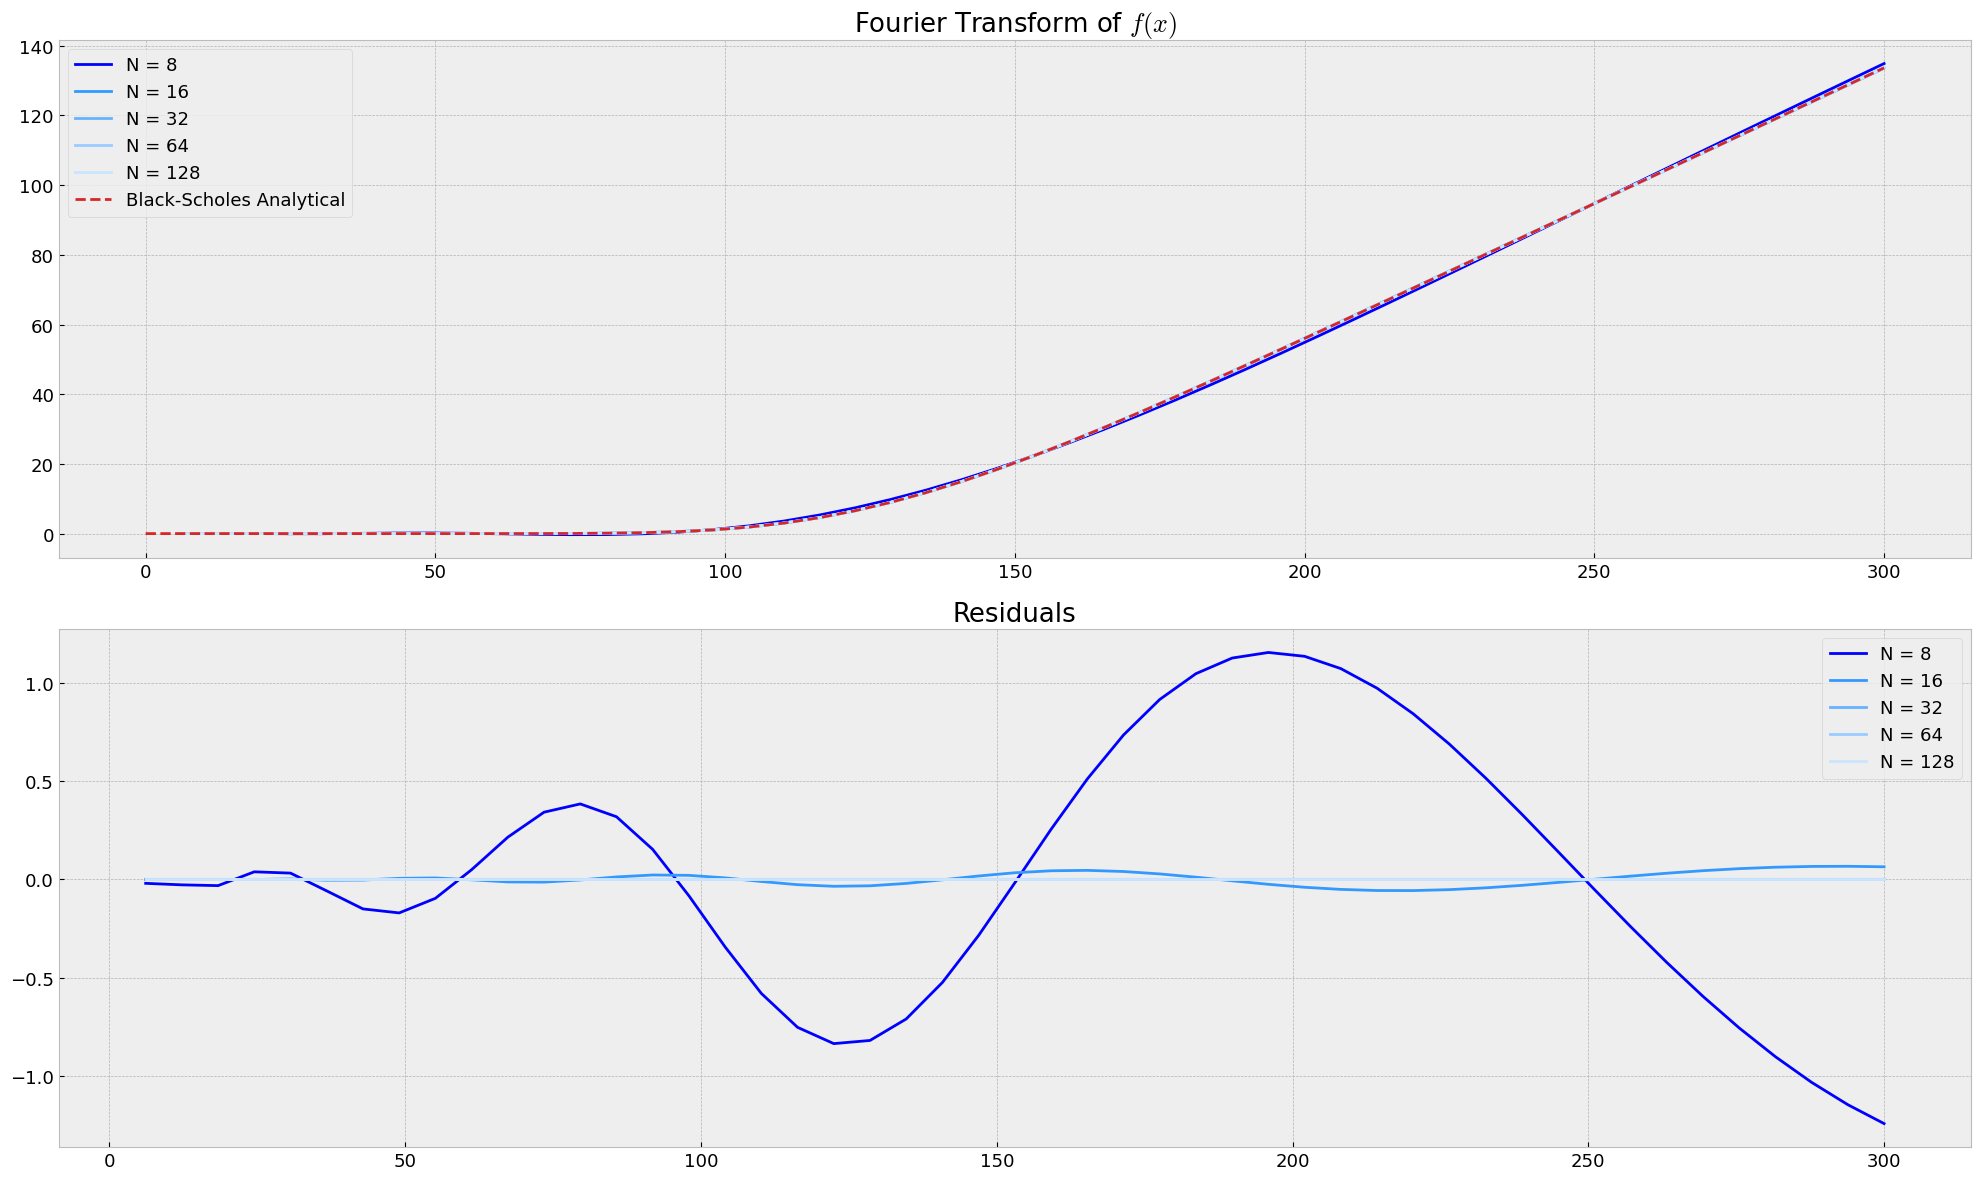

,avg_residuals,Ex. Time
N,,
8,5.075343e-01,0.003462
16,2.556765e-02,0.000064
32,5.810656e-06,0.000089
64,2.319065e-14,0.000078
128,2.319066e-14,0.000067


In [47]:
# --------------------------------------------------------------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))

results = {'N': [], 'avg_residuals': [] , 'Ex. Time' : []}
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):

    ex_time = []
    Ks      = np.linspace(0,300)
    Ps_F    = []
    Ps_A    = []
    for K in Ks:
        timer =perf_counter()
        Ps_F.append( Fourier_BS_Put(S0=100, K=K, T=5, sigma=.1, r=0.05, N=N) )
        Ps_A.append( bs_put(S0=100, K=K, T=5, sigma=.1, r=0.05) )
        timer = perf_counter() - timer ; ex_time.append(timer)
    
    Ps_F, Ps_A = np.array(Ps_F), np.array(Ps_A)

    ax1.plot(Ks,Ps_F, blue_shades[i], label=f'N = {N}')
    ax2.plot(Ks,(Ps_A-Ps_F), blue_shades[i], label=f'N = {N}')
    results['N'].append(N)
    results['avg_residuals'].append(np.nanmean(np.abs(Ps_A-Ps_F)))
    results['Ex. Time'].append(np.mean(ex_time))

ax1.set_title(r'Fourier Transform of $f(x)$')
ax1.plot(Ks,Ps_A,'tab:red', linestyle='--', label='Black-Scholes Analytical')
ax2.set_title('Residuals')
plt.tight_layout() ; ax1.legend() ; ax2.legend() ; plt.show()

pd.DataFrame.from_dict(results).set_index('N')

## Importance of correct limits [a, b]

Average Absulute Error for sigma(0.05) and N(128)= 7.676799e-12
Average Absulute Error for sigma(0.05) and N(128)= 2.830925e-02
Average Absulute Error for sigma(0.2) and N(128)= 1.405853e-03


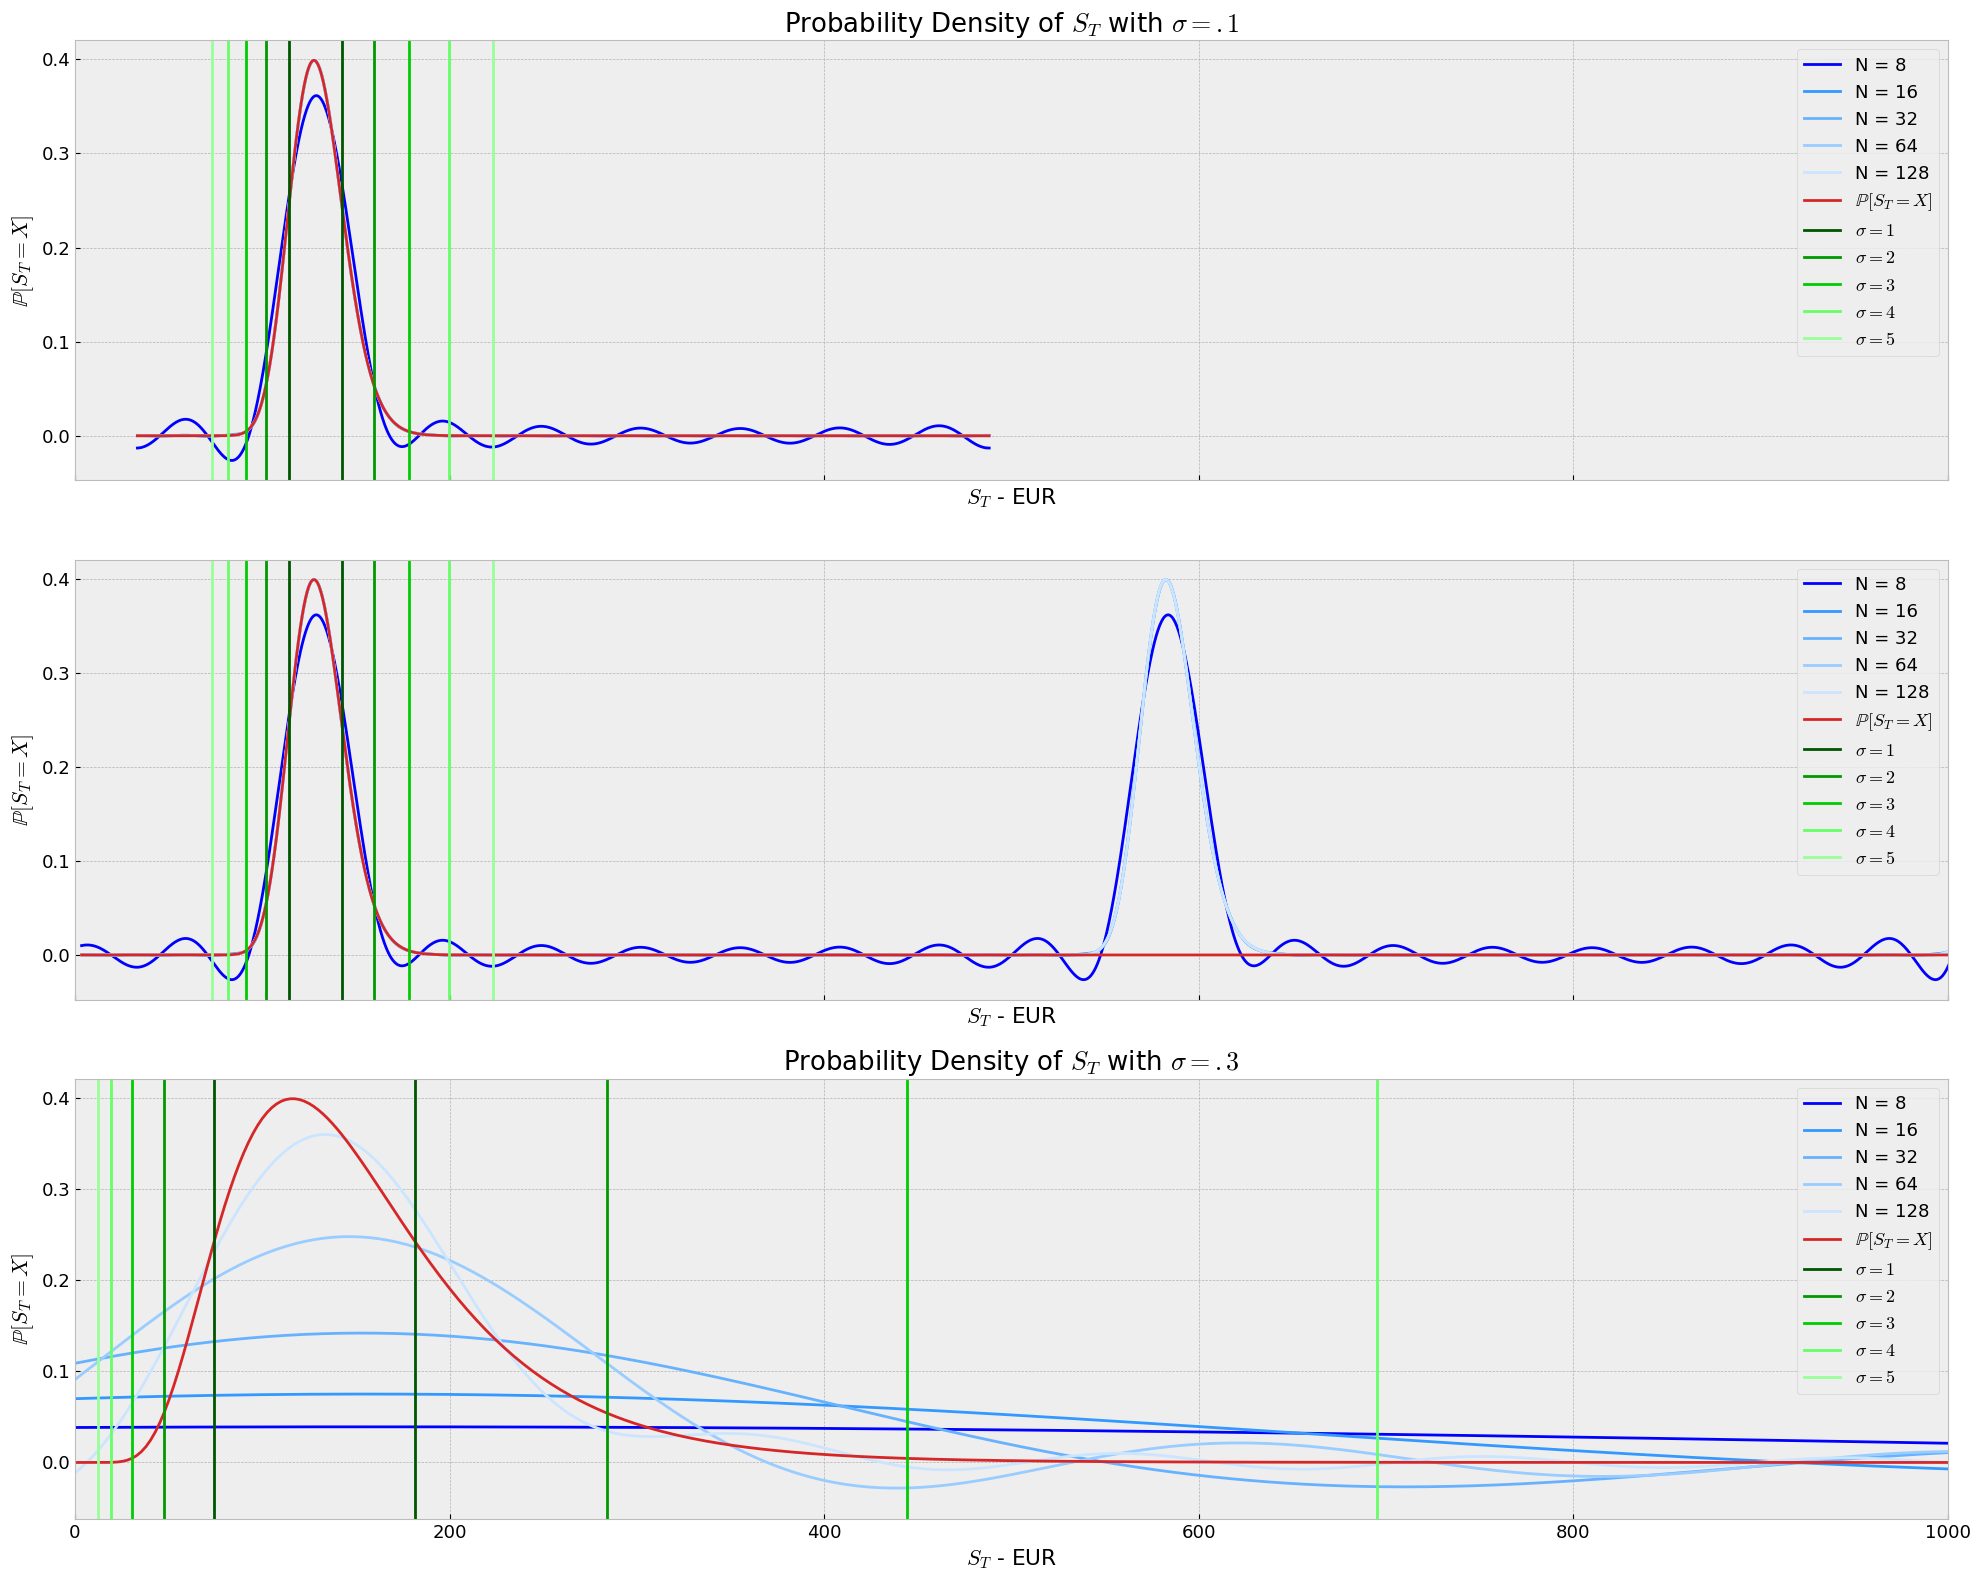

In [48]:
S0, T, r = 100, 5, .05

S_T     = lambda z : S0*exp((r-.5*sigma**2)*T + sigma*sqrt(T)*z)
S_T_inv = lambda S_T : (log(S0/S_T) + (r - .5*sigma**2)*T)/(sqrt(T)*sigma)
f       = lambda S_T : norm.pdf(S_T_inv(S_T)) # P[S_T = X]

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20,16), sharex=True)
ax1.set_title(r'Probability Density of $S_T$ with $\sigma=.1$')
#------------------------------------------------------------------------------------------------
sigma = .05
x   = np.linspace(S_T(-12), S_T(12), 10_000)
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):
    fx = get_fourier_approx(f=f, x=x, a=S_T(-12), b=S_T(12), N=N)
    ax1.plot(x,fx, blue_shades[i], label=f'N = {N}')
print(f'Average Absulute Error for sigma({sigma}) and N(128)= {np.abs(fx - f(x)).mean():e}')
ax1.plot(x,f(x), label=r'$\mathbb{P}[S_T = X]$', color='tab:red')
ax1.axvline(x = S_T(1), color=green_shades[0], label = r'$\sigma = 1$')
ax1.axvline(x = S_T(-1), color=green_shades[0])
ax1.axvline(x = S_T(2), color=green_shades[1], label = r'$\sigma = 2$')
ax1.axvline(x = S_T(-2), color=green_shades[1])
ax1.axvline(x = S_T(3), color=green_shades[2], label = r'$\sigma = 3$')
ax1.axvline(x = S_T(-3), color=green_shades[2])
ax1.axvline(x = S_T(4), color=green_shades[3], label = r'$\sigma = 4$')
ax1.axvline(x = S_T(-4), color=green_shades[3])
ax1.axvline(x = S_T(5), color=green_shades[4], label = r'$\sigma = 5$')
ax1.axvline(x = S_T(-5), color=green_shades[4])
ax1.set_xlim(0,1000) ; ax1.legend()
ax1.set_xlabel(r'$S_T$ - EUR') ; ax1.set_ylabel(r'$\mathbb{P}[S_T=X]$')

#------------------------------------------------------------------------------------------------
sigma = .05
x   = np.linspace(S_T(-32), S_T(32), 10_000)
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):
    fx = get_fourier_approx(f=f, x=x, a=S_T(-12), b=S_T(12), N=N)
    ax2.plot(x,fx, blue_shades[i], label=f'N = {N}')
print(f'Average Absulute Error for sigma({sigma}) and N(128)= {np.abs(fx - f(x)).mean():e}')
ax2.plot(x,f(x), label=r'$\mathbb{P}[S_T = X]$', color='tab:red')
ax2.axvline(x = S_T(1), color=green_shades[0], label = r'$\sigma = 1$')
ax2.axvline(x = S_T(-1), color=green_shades[0])
ax2.axvline(x = S_T(2), color=green_shades[1], label = r'$\sigma = 2$')
ax2.axvline(x = S_T(-2), color=green_shades[1])
ax2.axvline(x = S_T(3), color=green_shades[2], label = r'$\sigma = 3$')
ax2.axvline(x = S_T(-3), color=green_shades[2])
ax2.axvline(x = S_T(4), color=green_shades[3], label = r'$\sigma = 4$')
ax2.axvline(x = S_T(-4), color=green_shades[3])
ax2.axvline(x = S_T(5), color=green_shades[4], label = r'$\sigma = 5$')
ax2.axvline(x = S_T(-5), color=green_shades[4])
ax2.set_xlim(0,1000) ; ax2.legend()
ax2.set_xlabel(r'$S_T$ - EUR') ; ax2.set_ylabel(r'$\mathbb{P}[S_T=X]$')

#------------------------------------------------------------------------------------------------
ax3.set_title(r'Probability Density of $S_T$ with $\sigma=.3$')
sigma = .2
x   = np.linspace(S_T(-12), S_T(12), 10_000)
for i, N in enumerate(Ns):
    fx = get_fourier_approx(f=f, x=x, a=S_T(-12), b=S_T(12), N=N)
    ax3.plot(x,fx, blue_shades[i], label=f'N = {N}')
print(f'Average Absulute Error for sigma({sigma}) and N(128)= {np.abs(fx - f(x)).mean():e}')
ax3.plot(x,f(x), label=r'$\mathbb{P}[S_T = X]$', color='tab:red')
ax3.axvline(x = S_T(1), color=green_shades[0], label = r'$\sigma = 1$')
ax3.axvline(x = S_T(-1), color=green_shades[0])
ax3.axvline(x = S_T(2), color=green_shades[1], label = r'$\sigma = 2$')
ax3.axvline(x = S_T(-2), color=green_shades[1])
ax3.axvline(x = S_T(3), color=green_shades[2], label = r'$\sigma = 3$')
ax3.axvline(x = S_T(-3), color=green_shades[2])
ax3.axvline(x = S_T(4), color=green_shades[3], label = r'$\sigma = 4$')
ax3.axvline(x = S_T(-4), color=green_shades[3])
ax3.axvline(x = S_T(5), color=green_shades[4], label = r'$\sigma = 5$')
ax3.axvline(x = S_T(-5), color=green_shades[4])
ax3.set_xlim(0,1000) ; ax3.legend()
ax3.set_xlabel(r'$S_T$ - EUR'); ax3.set_ylabel(r'$\mathbb{P}[S_T=X]$')

plt.tight_layout()

## Convergence over N

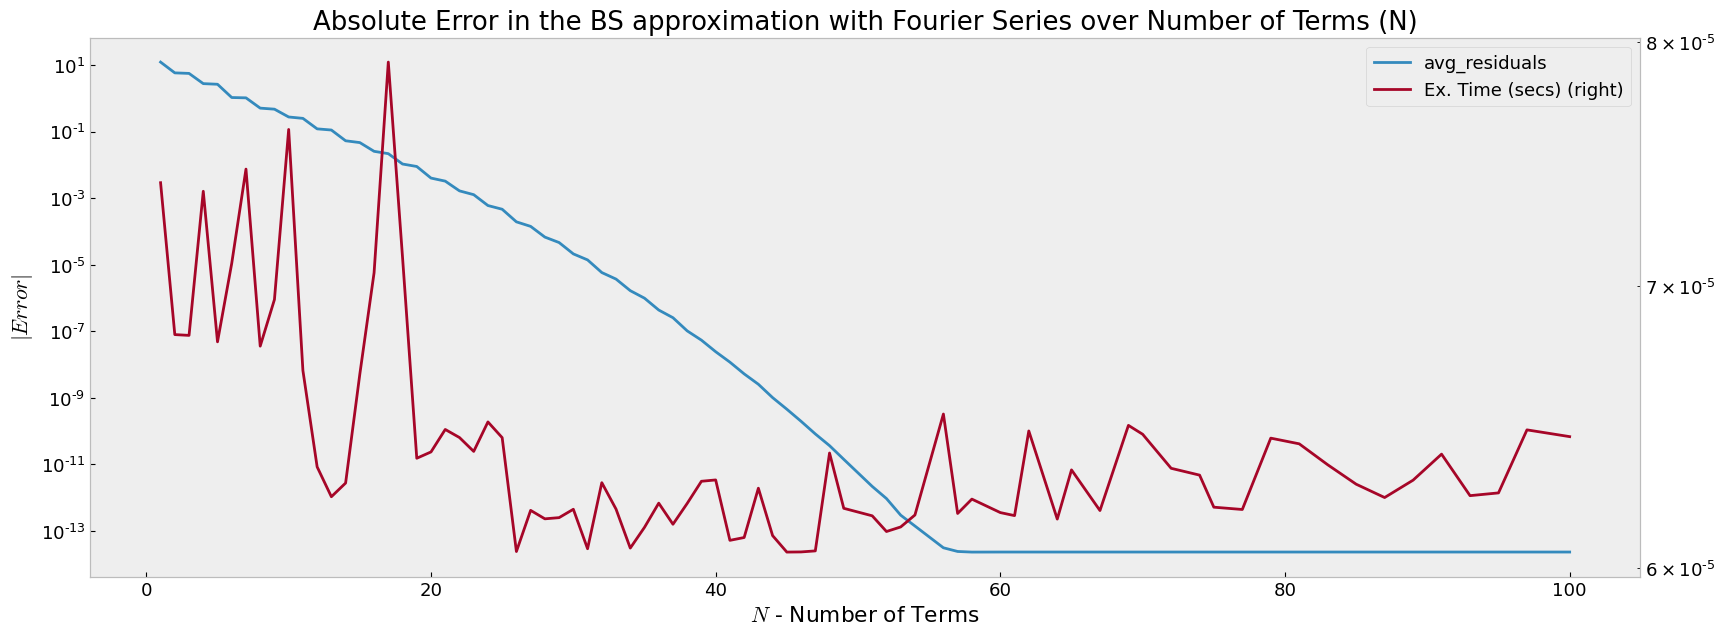

In [49]:
results = {'N': [], 'avg_residuals': [] , 'Ex. Time (secs)' : []}

Ns = np.unique(np.logspace(0, np.log10(100), num=200, base=10, dtype=int))
for i, N in enumerate(Ns):

    ex_time = []
    Ks      = np.linspace(0,300)
    Ps_F    = []
    Ps_A    = []
    for K in Ks:
        timer =perf_counter()
        Ps_F.append( Fourier_BS_Put(S0=100, K=K, T=5, sigma=.1, r=0.05, N=N) )
        Ps_A.append( bs_put(S0=100, K=K, T=5, sigma=.1, r=0.05) )
        timer = perf_counter() - timer ; ex_time.append(timer)
    
    Ps_F, Ps_A = np.array(Ps_F), np.array(Ps_A)
    results['N'].append(N)
    results['avg_residuals'].append(np.nanmean(np.abs(Ps_A-Ps_F)))
    results['Ex. Time (secs)'].append(np.mean(ex_time))

results = pd.DataFrame.from_dict(results).set_index('N')
results.plot(secondary_y='Ex. Time (secs)', logy=True, title='Absolute Error in the BS approximation with Fourier Series over Number of Terms (N)', 
    xlabel=r'$N$ - Number of Terms', ylabel=r'$|Error|$')
plt.show()
# results
    

## Error over different values

In [50]:
S0_A    = np.array([100])
K_A     = np.linspace(0,    500,    25)
# K_A    = np.array([100])
T_A     = np.logspace(np.log10(1/365), np.log10(2),     25)
r_A     = np.linspace(-.03, 0.20,   25)
# r_A    = np.array([.05])
sigma_A = np.linspace(.05,  1,      25)

grid = np.stack(np.meshgrid(S0_A, K_A, T_A, r_A, sigma_A), axis=-1).reshape(-1, 5)

results = {'S0': [], 'K': [], 'T': [], 'r': [], 'sigma': [], 'Fourier Series': [], 'Analytical': []}
for S0, K, T, r, sigma in tqdm(grid):
    results['S0'].append(S0) ; results['K'].append(K) ; results['T'].append(T) ; results['r'].append(r) ; results['sigma'].append(sigma)
    results['Fourier Series'].append( Fourier_BS_Put(S0=S0, K=K, T=T, sigma=sigma, r=r, N=256) )
    results['Analytical'].append( bs_put(S0=S0, K=K, T=T, sigma=sigma, r=r) )
    
results_df = pd.DataFrame.from_dict(results)
results_df = results_df[~results_df['Fourier Series'].isnull()]
results_df['Error'] = abs(results_df['Fourier Series'] - results_df['Analytical'])
results_df['RE'] = abs(results_df['Fourier Series'] - results_df['Analytical'])/results_df['Analytical']

print(f'>>Mean Error: {results_df.Error.mean()}')
results_df.sort_values('Error', ascending=False).head(10)

100%|██████████| 390625/390625 [00:31<00:00, 12299.80it/s]


>>Mean Error: 6.310922312374584e-07


,S0,K,T,r,sigma,Fourier Series,Analytical,Error,RE
78675,100.0,104.166667,0.00274,0.180833,0.05,4.114681,4.115072,0.000391,0.000095
78650,100.0,104.166667,0.00274,0.171250,0.05,4.117415,4.117805,0.000391,0.000095
78700,100.0,104.166667,0.00274,0.190417,0.05,4.111948,4.112338,0.000390,0.000095
78625,100.0,104.166667,0.00274,0.161667,0.05,4.120149,4.120539,0.000390,0.000095
78725,100.0,104.166667,0.00274,0.200000,0.05,4.109215,4.109605,0.000390,0.000095
78600,100.0,104.166667,0.00274,0.152083,0.05,4.122884,4.123273,0.000389,0.000094
78575,100.0,104.166667,0.00274,0.142500,0.05,4.125620,4.126007,0.000387,0.000094
78550,100.0,104.166667,0.00274,0.132917,0.05,4.128357,4.128741,0.000383,0.000093
78525,100.0,104.166667,0.00274,0.123333,0.05,4.131095,4.131475,0.000379,0.000092
78500,100.0,104.166667,0.00274,0.113750,0.05,4.133834,4.134209,0.000375,0.000091


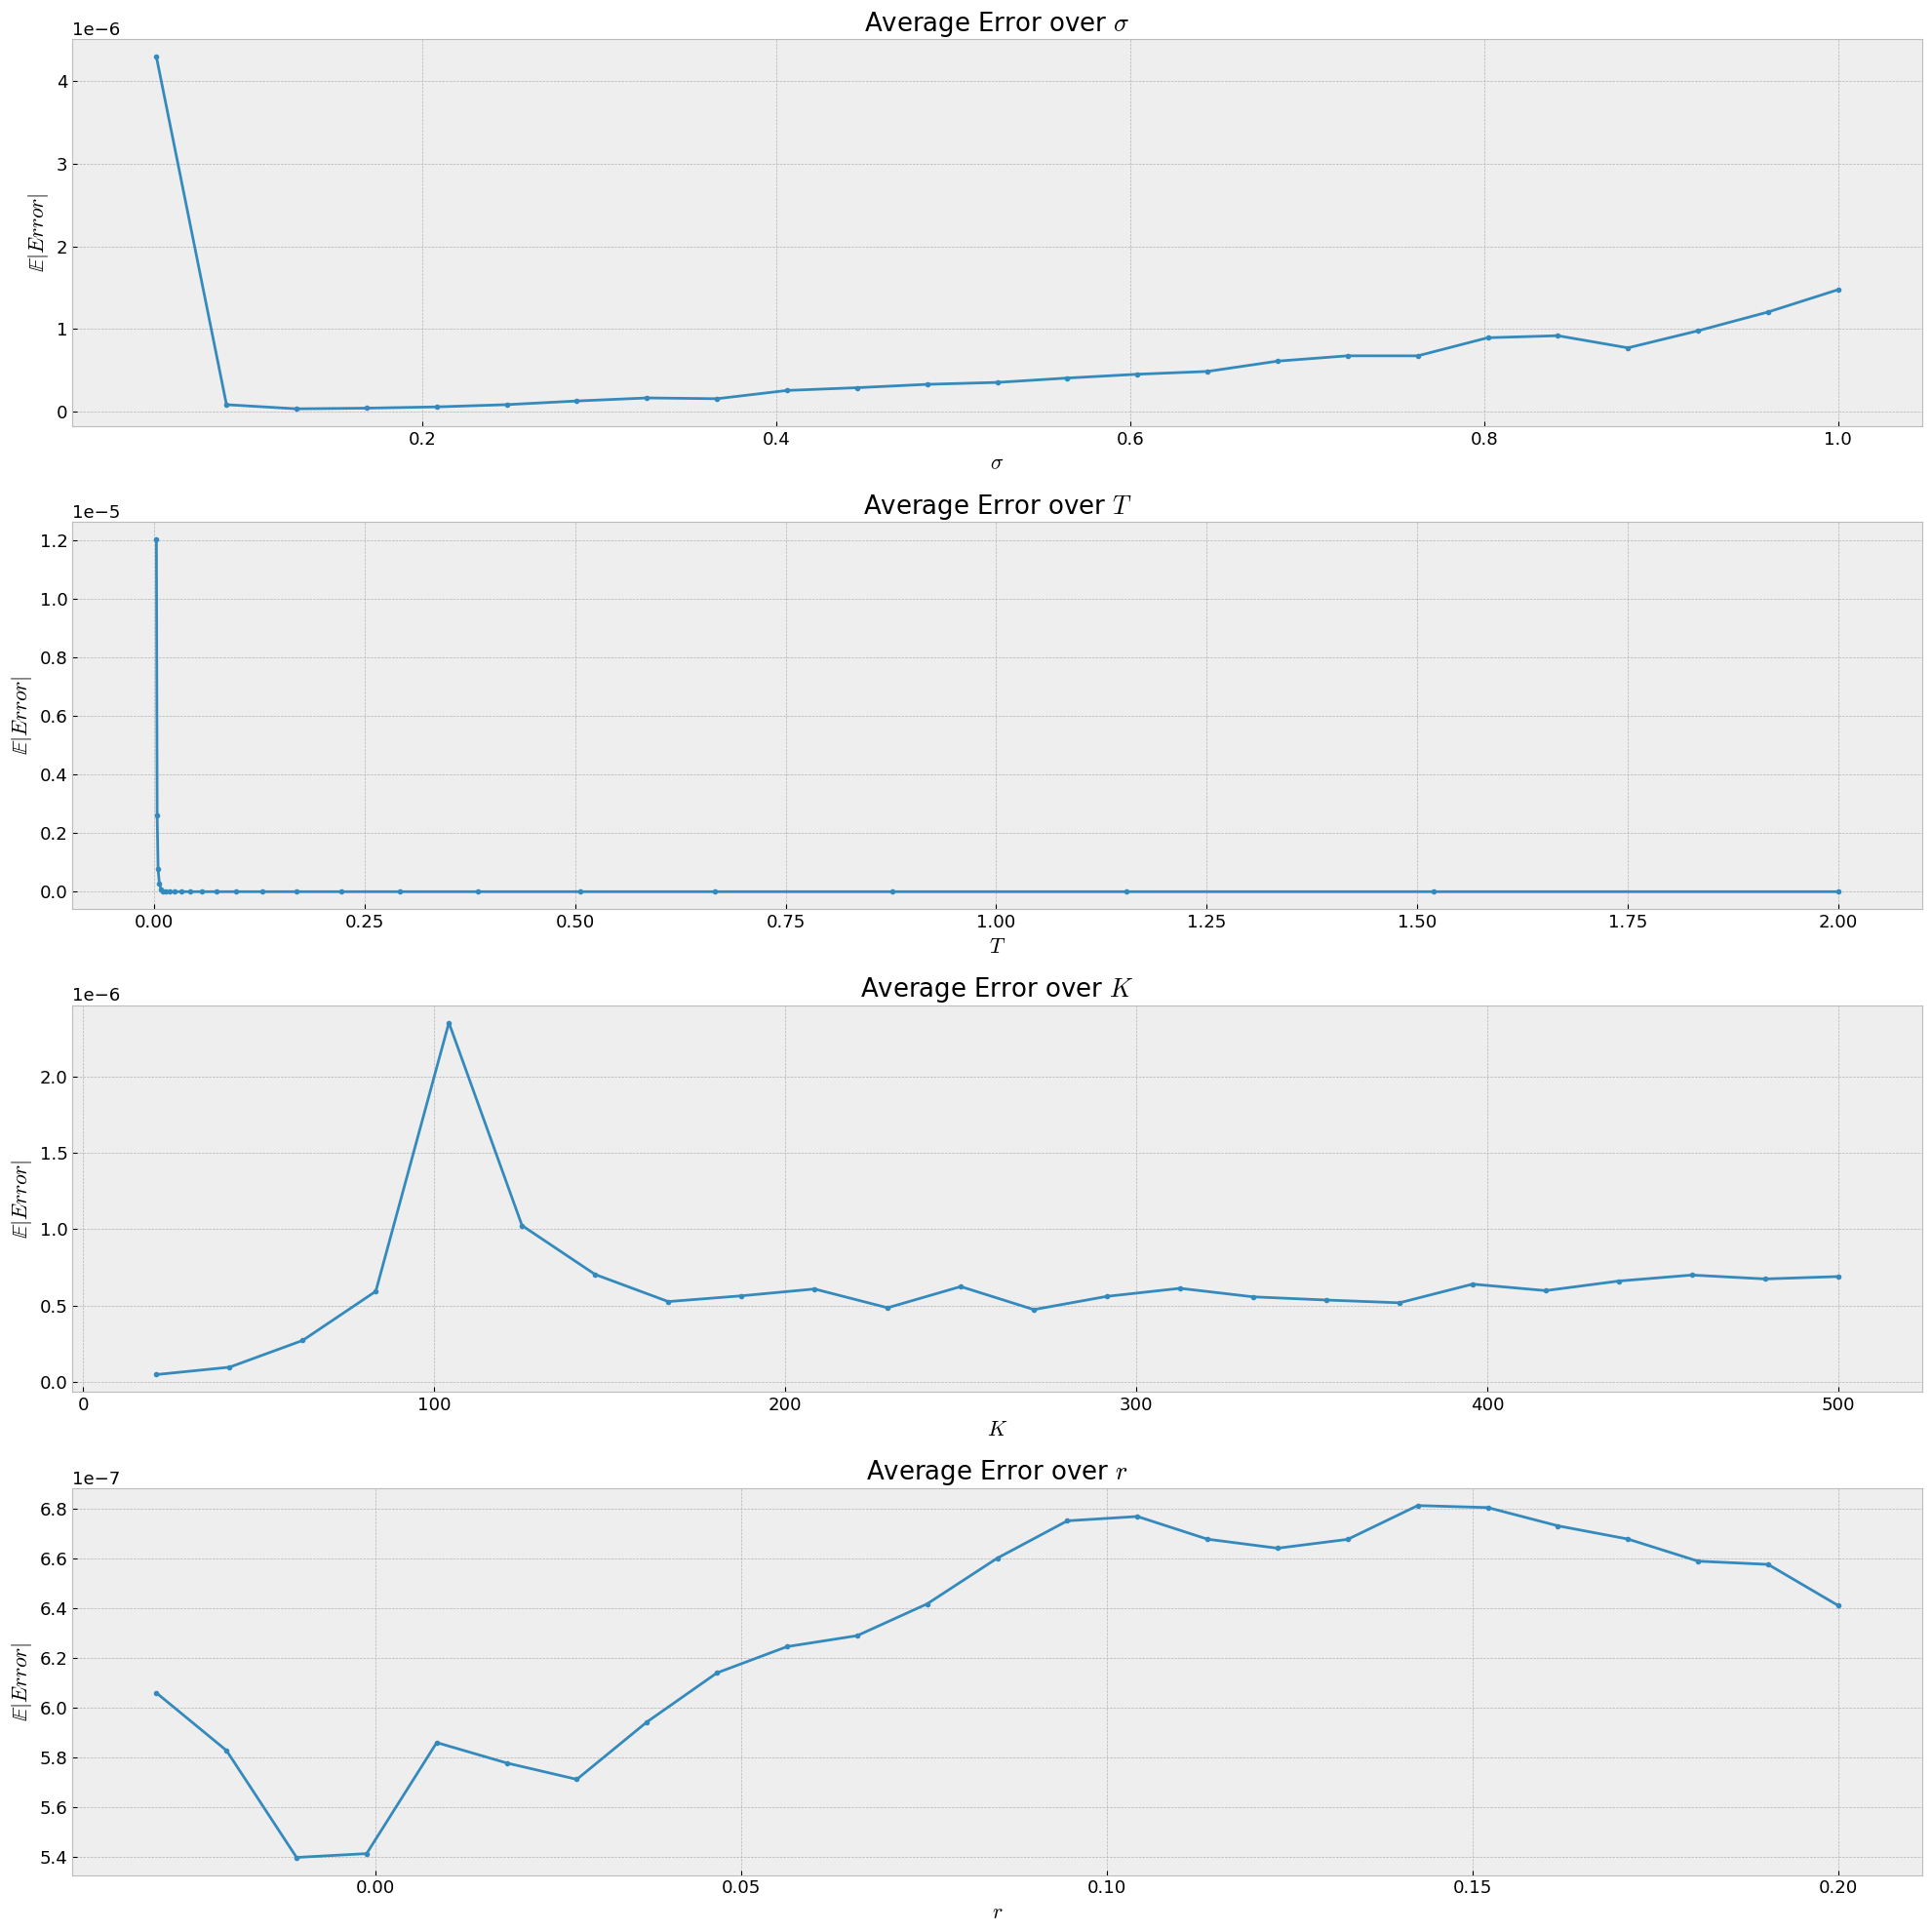

In [51]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(20,20))
results_df.groupby('sigma')['Error'].mean().plot(ax=ax1, title=r'Average Error over $\sigma$', xlabel=r'$\sigma$', ylabel=r'$\mathbb{E}|Error|$', marker='.')
results_df.groupby('T')['Error'].mean().plot(ax=ax2, title=r'Average Error over $T$', xlabel=r'$T$', ylabel=r'$\mathbb{E}|Error|$', marker='.')
results_df.groupby('K')['Error'].mean().plot(ax=ax3, title=r'Average Error over $K$', xlabel=r'$K$', ylabel=r'$\mathbb{E}|Error|$', marker='.')
results_df.groupby('r')['Error'].mean().plot(ax=ax4, title=r'Average Error over $r$', xlabel=r'$r$', ylabel=r'$\mathbb{E}|Error|$', marker='.')

plt.tight_layout()

# Part 3

## Heston Model 
$$\begin{align*}
& dS_t      &=\;& \mu S_t dt + \sqrt{\nu_t}S_t dW_t^S, \\
& d\nu_t    &=\;& \kappa(\theta - \nu_t)dt + \zeta \sqrt{\nu_t}dW_t^\nu \\
\\
& \nu_0, &=\;& \text{The initial variance} \\
& \kappa, &=\;& \text{The speed of the mean reversion} \\
& \theta, &=\;& \text{The long term mean variance} \\
& \zeta, &=\;& \text{The volatility of the volatility "vol of vol"} \\
& \rho, &=\;& \text{The correlation of the two weiner proceses} \\
\end{align*}$$

## Heston Model - Characteristic Function
$$\begin{align*}
& \varphi(u) &=\;& \mathbb{E}^\mathbb{Q}[e^{iu\;log(S_T)}|F_t] = e^{ium +\alpha + \beta v_t}\\ 
& m &=\;& log(S_t) + (r - \delta)(T-t) \\
& \alpha &=\;& \frac{\kappa\theta}{\zeta^2}\Bigg[   
    (\kappa - \rho\zeta iu - d)(T-t) - 2log(\frac{1-ce^{-d(T-t)}}{1 - c}) \Bigg] \\
& \beta &=\;& \frac{(\kappa - \rho\zeta iu - \delta)(1-e^{-d(T-t)})}{\zeta^2 (1-ce^{-d(T-t))}} \\
& c &=\;& \frac{(\kappa - \rho\zeta iu - d)}{(\kappa - \rho\zeta iu + d)}\\
& d &=\;& \sqrt{(\rho\zeta iu - \kappa)^2 + \zeta^2(iu+u^2)} \\
\end{align*}$$

## Heston Model Limits
$$\begin{align*}
& [a,b] &=\;& [c_1-12\sqrt{[c_2|]}, c_1+12\sqrt{[c_2|]}] \\
& c_1   &=\;& rT + (1-e^{-\kappa T})\frac{\theta - \nu_0}{2\kappa} - \frac{1}{2}\theta T \\
& c_2   &=\;& \frac{1}{8 \kappa^3}\left(\zeta T \kappa e^{-\kappa T}\left(u_0-\theta\right)(8 \kappa \rho-4 \zeta)\right. \\
&&& +\kappa \rho \zeta\left(1-e^{-\kappa T}\right)\left(16 \theta-8 u_0\right) \\
&&& +2 \theta \kappa T\left(-4 \kappa \rho \zeta+\zeta^2+4 \kappa^2\right) \\
&&& +\zeta^2\left(\left(\theta-2 u_0\right) e^{-2 \kappa T}+\theta\left(6 e^{-\kappa T}-7\right)+2 u_0\right) \\
&&& \left.+8 \kappa^2\left(u_0-\theta\right)\left(1-e^{-\kappa T}\right)\right)
\end{align*}$$


In [37]:
@njit
def Fourier_Heston_Put(S0, K, T, r, 
                    # Heston Model Paramters
                    kappa, # Speed of the mean reversion 
                    theta, # Long term mean
                    rho,   # correlation between 2 random variables
                    zeta,  # Volatility of volatility
                    v0,    # Initial volatility 
                    opt_type,
                    N = 2048):

    def heston_char(u, kappa, theta, rho, zeta, v0): 
        d = sqrt((rho*zeta*1j*u - kappa)**2 + zeta**2*(1j*u + u**2))
        g = (kappa - rho*zeta*1j*u - d)/(kappa - rho*zeta*1j*u + d)
        return (
            exp(1j*u*(log(S0)))
            * exp(theta*kappa*zeta**(-2)*(-2*log((1-g*exp(-T))/(1 - g))))
            * exp(v0**2*zeta**(-2)*(kappa - rho*zeta*1j*u -d)*(1 - exp(-T))/(1-g*exp(-T)))
        )

    # Parameters for the Function to make sure the approximations are correct.
    c1 = log(S0) + r*T + (1 - exp(-kappa*T))*(theta-v0)/(2*kappa) - (1/2)*theta*T
    c2 = (
        (1/(8*kappa**3)) * (zeta*T*kappa*exp(-kappa*T)*(v0-theta)*(8*kappa*rho-4*zeta)
        + kappa*rho*zeta*(1-exp(-kappa*T))*(16*theta-8*v0)
        + 2*theta*kappa*T*(-4*kappa*rho*zeta + zeta**2 + 4*kappa**2)
        + zeta**2*((theta - 2*v0)*exp(-2*kappa*T) + theta*(6*exp(-kappa*T)-7) + 2*v0)
        + 8*kappa**2*(v0-theta)*(1-exp(-kappa*T)))
    )
    a = c1 - 12*sqrt(abs(c2))
    b = c1 + 12*sqrt(abs(c2))

    h       = lambda n : (n*pi) / (b-a) 
    g       = lambda n : (exp(a) - (K/h(n))*sin(h(n)*(a - log(K))) - K*cos(h(n)*(a - log(K)))) / (1 + h(n)**2)
    g0      = K*(log(K) - a - 1) + exp(a)
    

    F = g0 
    for n in range(1, N+1):
        h_n = h(n)
        F += 2*heston_char(h_n, kappa, theta, rho, zeta, v0) * exp(-1j*a*h_n) * g(n)

    F = exp((-r*T))/(b-a) * np.real(F)
    F = F if opt_type == 'p' else F + S0 - K*exp(-r*T)
    return F if F > 0 else 0

In [38]:
args = {
'S0'      : 100.0 ,
# 'K'       : 100.0 ,
'r'       : 0.05 ,
# 'T'       : 5.0 ,

'kappa' : 1.5768,   # rate of mean reversion of variance process
'theta' : 0.0398,   # long-term mean variance
'zeta' : 0.3,       # volatility of volatility
'rho' : -0.5711,    # correlation between variance and stock process
'v0' : 0.1,         # initial variance

'N' : 96
}
args['K'] = 100.0
args['T'] = 1/12
# Fourier_Heston_Put(**args) 

TypeError: missing argument 'opt_type'

In [40]:
args = {
'S0'      : 100.0 ,
# 'K'       : 100.0 ,
'r'       : 0.05 ,
# 'T'       : 5.0 ,

'kappa' : 1.5768,   # rate of mean reversion of variance process
'theta' : 0.0398,   # long-term mean variance
'zeta' : 0.3,       # volatility of volatility
'rho' : -0.5711,    # correlation between variance and stock process
'v0' : 0.1,         # initial variance

'N' : 96,
'opt_type' : 'p'
}

Ns = [8, 16,32, 64, 256]
df = {'N' : Ns, 'avg_residuals' : [], 'Ex. Time' : []}

Ks = np.linspace(0,300, 50)[1:]
Ts = np.array([1/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
Ts = np.linspace(0,1, 50)
Ts = np.logspace(np.log10(1/365),np.log10(1), 50)
Ts

results     = {
        'K'                 : [], 
        'T'                 : [],
        'Price Heston'      : [],
        }
for K in tqdm(Ks):
    for T in Ts:
        args['K'] = K
        args['T'] = T
        results['K'].append( K )
        results['T'].append( T )
        results['Price Heston'].append( Fourier_Heston_Put(**args) )



100%|██████████| 49/49 [00:02<00:00, 19.74it/s]


In [41]:
results2 = pd.DataFrame(results)
results2

fig = px.scatter_3d(results2, x='T', y='K', z='Price Heston', width=800, height=800, color='Price Heston')
fig.show()
results2

,K,T,Price Heston
0,6.122449,0.002740,149.907978
1,6.122449,0.003090,139.042538
2,6.122449,0.003486,128.541990
3,6.122449,0.003932,118.645383
4,6.122449,0.004435,109.662974
...,...,...,...
2445,300.000000,0.617779,193.933104
2446,300.000000,0.696827,193.136219
2447,300.000000,0.785989,192.301965
2448,300.000000,0.886560,191.332590


## Implied Volatility Surface